# Paris

Дана выборка недвижимости в Париже в файле ParisHousing.csv

Необходимо определить оптимальное число кластеров для данной выборки при помощи метода kMeans с использованием метода “локтя” с шагом 20 

[Метод локтя](http://espressocode.top/elbow-method-for-optimal-value-of-k-in-kmeans/)

## 1. Разведочный анализ

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('Data/ParisHousing.csv', index_col=0)
df.head()

,squareMeters,numberOfRooms,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,category,PoolAndYard
0,75523,three,63,9373,3,8,2005,False,True,4313,9005,956,False,7,7559081.5,Basic,has pool and no yard
1,80771,thirty-nine,98,39381,8,6,2015,True,False,3653,2436,128,True,2,8085989.5,Luxury,has pool and has yard
2,55712,fifty-eight,19,34457,6,8,2021,False,False,2937,8852,135,True,9,5574642.1,Basic,has pool and no yard
3,32316,forty-seven,6,27939,10,4,2012,False,True,659,7141,359,False,3,3232561.2,Basic,no pool and no yard
4,70429,nineteen,90,38045,3,7,1990,True,False,8435,2429,292,True,4,7055052.0,Luxury,has pool and has yard


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   squareMeters       10000 non-null  int64  
 1   numberOfRooms      10000 non-null  object 
 2   floors             10000 non-null  int64  
 3   cityCode           10000 non-null  int64  
 4   cityPartRange      10000 non-null  int64  
 5   numPrevOwners      10000 non-null  int64  
 6   made               10000 non-null  int64  
 7   isNewBuilt         10000 non-null  bool   
 8   hasStormProtector  10000 non-null  bool   
 9   basement           10000 non-null  int64  
 10  attic              10000 non-null  int64  
 11  garage             10000 non-null  int64  
 12  hasStorageRoom     10000 non-null  bool   
 13  hasGuestRoom       10000 non-null  int64  
 14  price              10000 non-null  float64
 15  category           10000 non-null  object 
 16  PoolAndYard        1000

In [5]:
df['numberOfRooms'].unique()

array(['three', 'thirty-nine', 'fifty-eight', 'forty-seven', 'nineteen',
       'thirty-six', 'ten', 'one hundred', 'forty-two', 'twenty-one',
       'seventy-four', 'thirty-one', 'forty-four', 'sixty',
       'eighty-eight', 'thirty-seven', 'forty-three', 'sixty-four',
       'twelve', 'fifty-one', 'fifty-six', 'forty-six', 'seventy-two',
       'seven', 'ninety-eight', 'forty', 'seventy-eight', 'eighty-nine',
       'twenty-nine', 'eighty-seven', 'eight', 'twenty-seven',
       'fifty-nine', 'thirty-eight', 'forty-nine', 'sixty-six',
       'twenty-two', 'ninety-seven', 'twenty-five', 'fifty-two', 'eleven',
       'six', 'eighty-two', 'seventeen', 'fifty-seven', 'nine', 'fifteen',
       'forty-eight', 'five', 'twenty-eight', 'twenty', 'sixty-seven',
       'ninety-nine', 'seventy-three', 'fifty', 'sixty-nine', 'four',
       'seventy-five', 'sixty-one', 'fifty-five', 'ninety-two',
       'twenty-three', 'ninety-three', 'seventy-one', 'thirty-five',
       'ninety-four', 'twenty-four

Количесиво комнат представлено словами. Конвертируем числа в буквенном формате в циферный формат. Так модель сможет сравнивать примеры между собой

In [6]:
numbers = {'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5, 'six': 6, 'seven': 7, 'eight': 8,
         'nine': 9, 'ten': 10, 'eleven': 11, 'twelve': 12, 'thirteen': 13, 'fourteen': 14,
         'fifteen': 15, 'sixteen': 16, 'seventeen': 17, 'eighteen': 18, 'nineteen': 19,
         'twenty': 20, 'thirty': 30, 'forty': 40, 'fifty': 50, 'sixty': 60, 'seventy': 70,
         'eighty': 80, 'ninety': 90, 'one_hundred': 100}

In [7]:
def str_to_num(element):
    if 'one hundred' in element:
        element = element.replace('one hundred', 'one_hundred')
    
    lst = element.split('-')

    return sum([numbers[el] for el in lst if el in numbers])

In [8]:
df['numberOfRooms'] = df['numberOfRooms'].apply(str_to_num)

Факторизум категорию жилья

In [9]:
df['category'].unique()

array(['Basic', 'Luxury'], dtype=object)

In [10]:
df['category'] = df['category'].map({'Basic': 0, 'Luxury': 1})

Разделим колонку `PoolAndYard` на две для лучшего понимания

In [11]:
df['PoolAndYard'].unique()

array(['has pool and no yard', 'has pool and has yard',
       'no pool and no yard', 'no pool and has yard'], dtype=object)

In [12]:
def has_pool(cell):
    return 1 if 'has pool' in cell else 0

In [13]:
def has_yard(cell):
    return 1 if 'has yard' in cell else 0

In [14]:
df['hasPool'] = df['PoolAndYard'].apply(has_pool)

In [15]:
df['hasYard'] = df['PoolAndYard'].apply(has_yard)

Переведем в числа булевы выражения

In [16]:
new_built_factor, types = df['isNewBuilt'].factorize(sort=True)
df['isNewBuilt'] = new_built_factor

In [17]:
types

Index([False, True], dtype='object')

In [18]:
protector_factor, types = df['hasStormProtector'].factorize(sort=True)
df['hasStormProtector'] = protector_factor

In [19]:
types

Index([False, True], dtype='object')

In [20]:
protector_factor, types = df['hasStorageRoom'].factorize(sort=True)
df['hasStorageRoom'] = protector_factor

In [21]:
types

Index([False, True], dtype='object')

Данные после преобразования

In [22]:
df.head()

,squareMeters,numberOfRooms,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,category,PoolAndYard,hasPool,hasYard
0,75523,3,63,9373,3,8,2005,0,1,4313,9005,956,0,7,7559081.5,0,has pool and no yard,1,0
1,80771,39,98,39381,8,6,2015,1,0,3653,2436,128,1,2,8085989.5,1,has pool and has yard,1,1
2,55712,58,19,34457,6,8,2021,0,0,2937,8852,135,1,9,5574642.1,0,has pool and no yard,1,0
3,32316,47,6,27939,10,4,2012,0,1,659,7141,359,0,3,3232561.2,0,no pool and no yard,0,0
4,70429,19,90,38045,3,7,1990,1,0,8435,2429,292,1,4,7055052.0,1,has pool and has yard,1,1


In [23]:
df.drop('PoolAndYard', axis=1, inplace=True)

In [24]:
df.head()

,squareMeters,numberOfRooms,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,category,hasPool,hasYard
0,75523,3,63,9373,3,8,2005,0,1,4313,9005,956,0,7,7559081.5,0,1,0
1,80771,39,98,39381,8,6,2015,1,0,3653,2436,128,1,2,8085989.5,1,1,1
2,55712,58,19,34457,6,8,2021,0,0,2937,8852,135,1,9,5574642.1,0,1,0
3,32316,47,6,27939,10,4,2012,0,1,659,7141,359,0,3,3232561.2,0,0,0
4,70429,19,90,38045,3,7,1990,1,0,8435,2429,292,1,4,7055052.0,1,1,1


In [25]:
df.isna().sum()

squareMeters         0
numberOfRooms        0
floors               0
cityCode             0
cityPartRange        0
numPrevOwners        0
made                 0
isNewBuilt           0
hasStormProtector    0
basement             0
attic                0
garage               0
hasStorageRoom       0
hasGuestRoom         0
price                0
category             0
hasPool              0
hasYard              0
dtype: int64

## 2. Класстеризация KMeans

In [26]:
inertias = []
K = range(1,123, 20)

for k in K:

    # Построение и подгонка модели

    kmeanModel = KMeans(n_clusters=k)

    kmeanModel.fit(df)
    inertias.append(kmeanModel.inertia_)

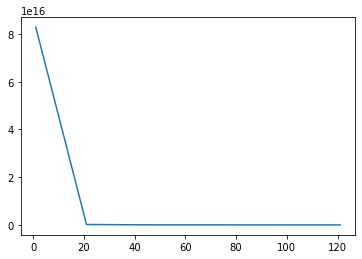

In [27]:
plt.plot(K, inertias)

In [28]:
inertias = []
K = range(1,100)

for k in K:

    # Построение и подгонка модели

    kmeanModel = KMeans(n_clusters=k)

    kmeanModel.fit(df)
    inertias.append(kmeanModel.inertia_)

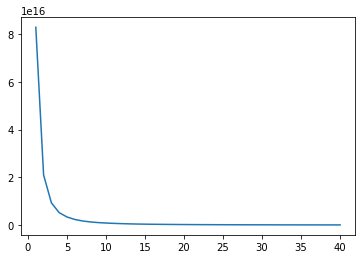

In [29]:
plt.plot(K[:40], inertias[:40])

Ответ 20😲